# A Simple Implementation of Flow Matching

## 1. Preliminary

In [1]:
# Torch
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader

# SK-Learn datasets
from sklearn.datasets import make_moons, make_swiss_roll
from sklearn.preprocessing import StandardScaler

# ODE Solver
from zuko.utils import odeint

# Type-hinting
from typing import overload

# Other tools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Choose device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [3]:
class VectorField(nn.Module):
    def __init__(self, net: nn.Module) -> None:
        super().__init__()
        self.net = net

    def forward(self, t: Tensor, x: Tensor) -> Tensor:
        return self.net(t, x)

    def wrapper(self, t: Tensor, x: Tensor) -> Tensor:
        t = t * torch.ones(len(x), device=x.device)
        return self(t, x)

    def decode_t0_t1(self, x_0: Tensor, t0: float, t1: float):
        return odeint(self.wrapper, x_0, t0, t1, self.parameters())

    def encode(self, x_1: Tensor):
        return odeint(self.wrapper, x_1, 1.0, 0.0, self.parameters())

    def decode(self, x_0: Tensor):
        return odeint(self.wrapper, x_0, 0.0, 1.0, self.parameters())

In [4]:
class PathDistribution:
    def __init__(self) -> None: ...

    @overload
    def psi(self, t: Tensor, x_0: Tensor, x_1: Tensor) -> Tensor: ...

    @overload
    def psi(self, t: Tensor, x_0: Tensor, x_1: Tensor, x_t: Tensor) -> Tensor: ...

    @overload
    def psi(self, *args, **kwargs) -> Tensor: ...

    def psi(self, *args, **kwargs) -> Tensor:
        raise NotImplementedError

    @overload
    def d_psi(self, x_0: Tensor, x_1: Tensor) -> Tensor: ...

    @overload
    def d_psi(self, x_0: Tensor, x_1: Tensor, x_t: Tensor) -> Tensor: ...

    @overload
    def d_psi(self, t: Tensor, x_0: Tensor, x_1: Tensor) -> Tensor: ...

    @overload
    def d_psi(self, t: Tensor, x_0: Tensor, x_1: Tensor, x_t: Tensor) -> Tensor: ...

    @overload
    def d_psi(self, *args, **kwargs) -> Tensor: ...

    def d_psi(self, *args, **kwargs) -> Tensor:
        raise NotImplementedError

    def p_0(self, *args, **kwargs) -> Tensor:
        raise NotImplementedError


class RectifiedPath(PathDistribution):

    def __init__(self, sig_min: float = 0.001, eps=1e-5) -> None:
        super().__init__()
        self.sig_min = sig_min
        self.eps = eps

    def psi(self, t: Tensor, x_0: Tensor, x_1: Tensor) -> Tensor:
        """
        Construct the path between x_0 and x_1
        """
        return (1 - (1 - self.sig_min) * t) * x_0 + t * x_1

    def d_psi(self, x_0: Tensor, x_1: Tensor) -> Tensor:
        """
        Construct the derivative of the path between x_0 and x_1
        """
        return x_1 - (1 - self.sig_min) * x_0

    def p_0(self, shape) -> Tensor:
        return torch.randn(shape)


def fm_loss(v_t: VectorField, pd: PathDistribution, x_1: Tensor) -> Tensor:
    """
    Compute the flow-matching loss.
    """

    # t ~ Unif([0, 1])
    t = (torch.rand(1) + torch.arange(len(x_1)) / len(x_1)) % 1
    t = t.to(x_1.device)
    t = t[:, None].expand(x_1.shape)

    x_0 = pd.p_0(x_1.shape).to(x_1.device)
    psi = pd.psi(t=t, x_0=x_0, x_1=x_1)
    d_psi = pd.d_psi(x_0=x_0, x_1=x_1)
    v_psi = v_t(t[:, 0], psi)

    return torch.mean((v_psi - d_psi) ** 2)


def fm_loss_bb(v_t: VectorField, pd: PathDistribution, x_1: Tensor) -> Tensor:
    """
    Compute the flow-matching loss with Brownian Bridge .
    """

    # t ~ Unif([0, 1])
    t = (torch.rand(1) + torch.arange(len(x_1)) / len(x_1)) % 1
    t = t.to(x_1.device)
    r = torch.sqrt(t * (1 - t))

    t = t[:, None].expand(x_1.shape)
    r = r[:, None].expand(x_1.shape)

    x_0 = pd.p_0(x_1.shape).to(x_1.device)
    psi = pd.psi(t=t, x_0=x_0, x_1=x_1) + 0.1 * r * torch.randn_like(r)
    d_psi = pd.d_psi(x_0=x_0, x_1=x_1)
    v_psi = v_t(t[:, 0], psi)

    return torch.mean((v_psi - d_psi) ** 2)

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, h_dims: list[int], n_frequencies: int) -> None:
        super().__init__()

        ins = [in_dim + 2 * n_frequencies] + h_dims
        outs = h_dims + [out_dim]
        self.n_frequencies = n_frequencies

        self.layers = nn.ModuleList(
            [nn.Sequential(nn.Linear(in_d, out_d), nn.LeakyReLU()) for in_d, out_d in zip(ins, outs)]
        )
        self.top = nn.Sequential(nn.Linear(out_dim, out_dim))

    def time_encoder(self, t: Tensor) -> Tensor:
        freq = 2 * torch.arange(self.n_frequencies, device=t.device) * torch.pi
        t = freq * t[..., None]
        return torch.cat((t.cos(), t.sin()), dim=-1)

    def forward(self, t: Tensor, x: Tensor) -> Tensor:
        # Extend the input with the time encoding
        t = self.time_encoder(t)
        x = torch.cat((x, t), dim=-1)

        # Pass through the layers
        for l in self.layers:
            x = l(x)
        x = self.top(x)

        return x

## 2. Test the model to a simple dataset

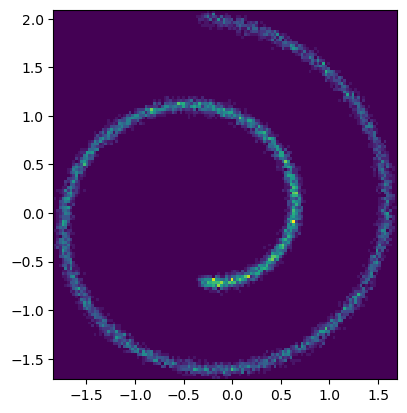

In [6]:
def get_data(dataset: str, n_points: int) -> np.ndarray:
    match dataset:
        case "moons":
            data, _ = make_moons(n_points, noise=0.15)
        case "swiss":
            data, _ = make_swiss_roll(n_points, noise=0.25)
            data = data[:, [0, 2]] / 10.0
        case _:
            raise ValueError(f"Unknown dataset: {dataset}")

    return StandardScaler().fit_transform(data)


dataset = "swiss"
n_points = 10_000

data = get_data(dataset, n_points)

plt.hist2d(data[:, 0], data[:, 1], bins=128)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

In [7]:
batch_size = 2048
dataset = torch.from_numpy(data).float()
dataset = dataset.to(device)
dataset = TensorDataset(dataset)
dataloader = DataLoader(dataset, batch_size=batch_size)

100%|███████████████████████████████████████████████| 1000/1000 [00:38<00:00, 26.19it/s]


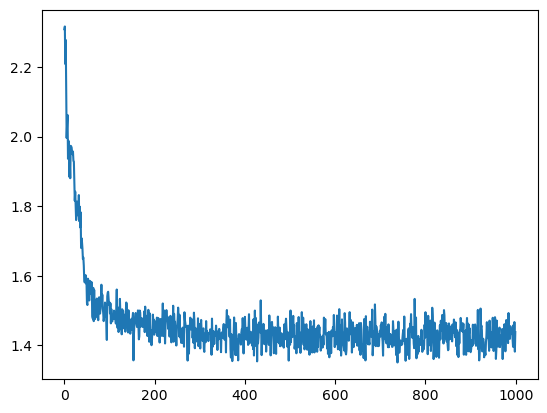

In [8]:
pd = RectifiedPath()
net = Net(2, 2, [512] * 5, 10).to(device)
v_t = VectorField(net)

# configure optimizer
optimizer = torch.optim.Adam(v_t.parameters(), lr=1e-3)
n_epochs = 1000

losses = np.zeros((n_epochs))

for epoch in tqdm(range(n_epochs), ncols=88):
    for batch in dataloader:
        x_1 = batch[0]

        # Epoch step
        optimizer.zero_grad()
        loss = fm_loss(v_t, pd, x_1)
        loss.backward()
        optimizer.step()

        # Record loss
        losses[epoch] = loss.item()


plt.plot(np.arange(len(losses)), losses)
plt.show()

Test if the original distribution is well-approximated.

In [9]:
# Sampling
n_samples = 10_000
with torch.no_grad():
    x_0 = pd.p_0((n_samples, 2)).to(device=device)
    x_1_hat = v_t.decode(x_0)

x_1_hat = x_1_hat.cpu().numpy()

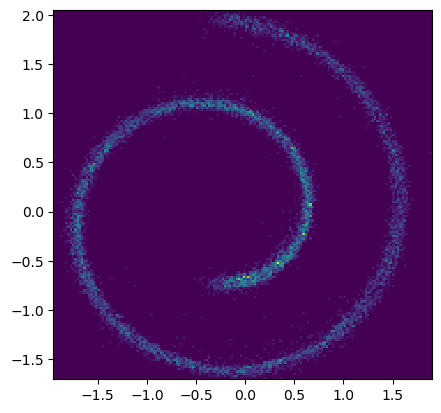

In [10]:
plt.hist2d(x_1_hat[:, 0], x_1_hat[:, 1], bins=164)
plt.gca().set_aspect("equal", adjustable="box")
plt.show()

Track the evolution of sample points.

In [13]:
# Sampling
n_samples = 200
n_steps = 200
t_steps = torch.linspace(0, 1, n_steps, device=device)

with torch.no_grad():
    x_t = [torch.randn(n_samples, 2, device=device)]
    for t in range(len(t_steps) - 1):
        x_t += [v_t.decode_t0_t1(x_t[-1], t_steps[t], t_steps[t + 1])]

x_t_numpy = np.array([x.detach().cpu().numpy() for x in x_t])

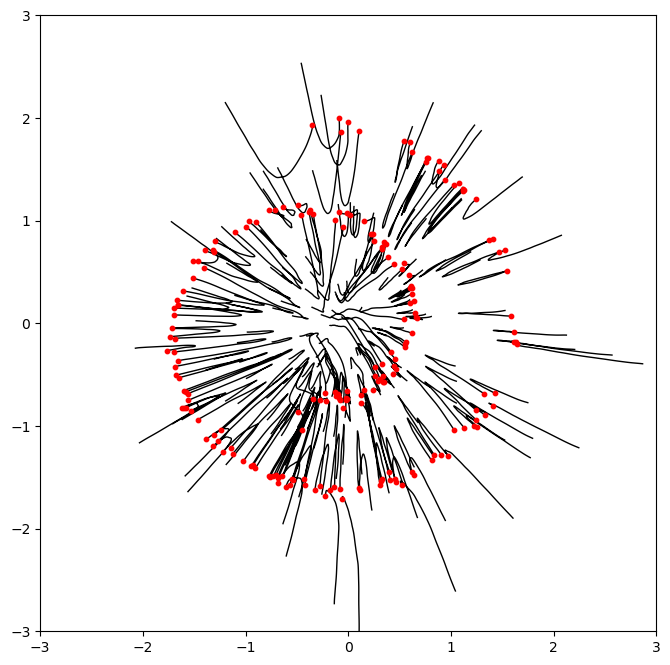

In [14]:
from matplotlib.collections import PathCollection
from matplotlib.path import Path


def to_path_code(path):
    assert len(path) >= 2
    codes = [Path.MOVETO] + [Path.LINETO] * (len(path) - 1)
    return codes


paths = x_t_numpy.transpose(1, 0, 2)

vertices = np.array(paths).reshape(-1, 2)
path_codes = np.concatenate([to_path_code(p) for p in paths])

path_collection = PathCollection(
    [Path(vertices, path_codes)],
    linewidths=1,
    facecolors="none",
    edgecolors="black",
)

fig, ax = plt.subplots(figsize=(8, 8))

ax.add_collection(path_collection)

ax.scatter(x_t_numpy[-1, :, 0], x_t_numpy[-1, :, 1], s=10, c="red")

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_aspect("equal", adjustable="box")

plt.show()

Checkerboard pattern

[[-0.51343678 -0.77187379]
 [-0.49526951 -0.2687853 ]
 [-0.17095134 -0.16511357]
 ...
 [-0.16662535 -0.42908381]
 [-0.74563044  0.37871676]
 [ 0.22566616  0.11477587]]


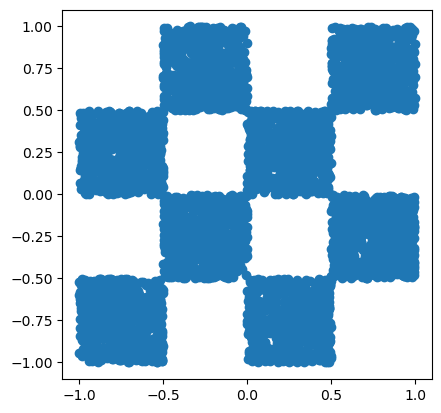

In [8]:
from sklearn.datasets import make_checkerboard
import numpy as np
import matplotlib.pyplot as plt


# Generate the checkerboard dataset
def generate_checkerboard(n_points: int, n_squares: int = 4, range_min=-1, range_max=1):
    square_size = (range_max - range_min) / n_squares

    position_map = np.array(
        [
            (range_min + i * square_size, range_min + j * square_size)
            for i in range(0, n_squares)
            for j in range(i % 2, n_squares, 2)
        ]
    )

    points = np.random.uniform(0, square_size, (n_points, 2))
    cells = np.random.randint(0, len(position_map), n_points)
    points = points + position_map[cells]

    return points


points = generate_checkerboard(5000, 4, -1, 1)
print(points)

plt.scatter(points[:, 0], points[:, 1])
plt.gca().set_aspect(aspect="equal", adjustable="box")
plt.show()

In [4]:
import numpy as np

x = np.random.randn(5)
choices = np.random.choice(np.arange(5), (3, 3))

x[choices]


array([[-2.01504051, -0.76758374, -1.71092463],
       [-0.76758374, -2.01504051, -1.71092463],
       [ 0.33986013, -0.17696475, -2.01504051]])